In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
from scipy.cluster import hierarchy as hc
import scipy.stats

In [53]:
raw_data = pd.read_pickle(r'/Users/peterfeng/Downloads/UChicago 2022 Winter/Machine Learning/Week 2/HW1/dataset.pkl')

In [114]:
# restricting to companies with Market Cap > 1 Billion
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [116]:
def f(x):
    if x > 0:
        return 1
    else:
        return -1
data['rel_performance'] = data['pred_rel_return'].apply(f)
data

actq        apq        atq       ceqq      cheq  \
date       ticker                                                         
2000-02-09 CSCO     7722.000    482.000  21391.000  16523.000  3968.000   
           ROP       172.725     19.662    474.649    239.432     3.198   
2000-02-10 CMOS      240.767     27.044    376.536    209.411    68.625   
2000-02-11 DELL     7681.000   3538.000  11471.000   5308.000  4132.000   
2000-02-15 VAL       507.082    139.497   1094.080    402.382    27.605   
...                      ...        ...        ...        ...       ...   
2018-12-21 NKE     15566.000   2574.000  22677.000   8729.000  4041.000   
           SAFM      566.489    128.936   1659.440   1387.893   121.193   
           SCHL     1172.300    250.300   2081.900   1284.600   358.100   
           WBA     20083.000  14660.000  69941.000  25609.000  1183.000   
2018-12-24 KMX      3057.419    558.324  18396.812   3435.113   461.662   

                       cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                    ...   
2000-02-09 CSCO     1422.000  3374.1250  3648.000  3445.000   0.000  ...   
           ROP        47.634    30.2688    31.217     0.000   0.000  ...   
2000-02-10 CMOS       43.023    21.4360    23.753     0.000   0.000  ...   
2000-02-11 DELL     5452.000  2536.0000  2731.000  2575.000   0.000  ...   
2000-02-15 VAL       221.366    43.1858    43.687    53.321   0.000  ...   
...                      ...        ...       ...       ...     ...  ...   
2018-12-21 NKE      5098.000  1601.1500  1620.700  1577.000  16.108  ...   
           SAFM      758.313    22.4290    22.191    22.100   0.884  ...   
           SCHL      262.400    35.0420    35.863     0.000   0.000  ...   
           WBA     25651.000   976.4750   951.400  1172.514  11.995  ...   
2018-12-24 KMX      3819.336   177.2235   175.321   171.785   3.658  ...   

                   sector_code_817.0  sector_code_822.0  sector_code_823.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   
...                              ...                ...                ...   
2018-12-21 NKE                     0                  0                  0   
           SAFM                    0                  0                  0   
           SCHL                    0                  0                  0   
           WBA                     0                  0                  0   
2018-12-24 KMX                     0                  0                  0   

                   sector_code_825.0  sector_code_830.0  sector_code_835.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   
...                              ...                ...                ...   
2018-12-21 NKE                     0                  0                  0   
           SAFM                    0                  0                  0   
           SCHL                    0                  0                  0   
           WBA                     0                  0                  0   
2018-12-24 KMX                     0                  0                  0   

                   sector_cod

In [120]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [121]:
# test_train_validation split
df = data.loc['2007-01-01': '2010-01-01']
df_valid = data.loc['2009-07-30': '2009-10-30']
df_test = data.loc['2010-01-01': '2019-01-01']

# train and validation
train_original = df.reset_index().drop(['ticker','date', 'next_period_return', 'spy_next_period_return',\
    'rel_performance','pred_rel_return', 'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid_original = df_valid.reset_index().drop(['ticker','date', 'next_period_return', 'spy_next_period_return',\
    'rel_performance','pred_rel_return', 'return', 'cum_ret', 'spy_cum_ret'],axis=1)

test_original = df_test.reset_index().drop(['ticker','date', 'next_period_return', 'spy_next_period_return',\
    'rel_performance','pred_rel_return', 'return', 'cum_ret', 'spy_cum_ret'],axis=1)

# stock returns 
train_ret = df['next_period_return']
valid_ret = df_valid['next_period_return']
test_ret = df_test['next_period_return']

# target labels
y_train = df['rel_performance'].values
y_valid = df_valid['rel_performance'].values
y_test = df_test['rel_performance'].values


In [123]:
t = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 800)
bg = BaggingClassifier(t, n_estimators = 40, oob_score = True, random_state = 123, n_jobs = 1)
bg.fit(train_original, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=800),
                  n_estimators=40, n_jobs=1, oob_score=True, random_state=123)

In [124]:
# bagging feature importance function
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

# plot feature importance
def plot_fi(fi): 
    return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

# profit importance function
def profit_importance(t, df, rets):
    np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(20):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

# bagging tree importance function
def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [125]:
# first find useful features with feature importance function
fi = baggingtree_feat_importance(bg, train_original)

# find feafures selected above
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
105,cf_yield,0.291166
180,fqtr_2,0.136397
95,evmq,0.041092
160,debt_assetsq,0.034785
0,actq,0.030570
162,de_ratioq,0.024585
118,roaq,0.023756
147,debt_ebitdaq,0.020888
152,ocf_lctq,0.020653
145,rect_actq,0.018083


<AxesSubplot:ylabel='cols'>

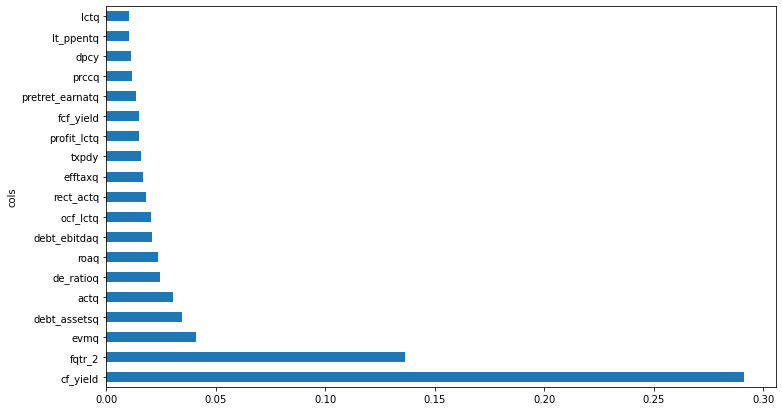

In [126]:
plot_fi(features)

In [127]:
# how many features we select in total
len(features['cols'].values)


19

In [130]:
# truncate the dataframe
train = train_original[features['cols'].values]
valid = valid_original[features['cols'].values]

In [131]:
# train the bagging
bg.fit(train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=800),
                  n_estimators=40, n_jobs=1, oob_score=True, random_state=123)

In [132]:
# find the profit importance
pi = baggingtree_profit_importance(bg, valid, valid_ret)
pi

,cols,pi_imp
0,cf_yield,53.000932
2,evmq,67.525482
1,fqtr_2,69.231027
12,profit_lctq,70.595473
4,actq,71.340660
8,ocf_lctq,71.398592
10,efftaxq,71.448125
18,lctq,72.008898
7,debt_ebitdaq,72.068038
15,prccq,72.159340


In [133]:
profits = []
feat = []

train_copy = train.copy()
valid_copy = valid.copy()

while len(train_copy.columns)>1:
    
    bg.fit(train_copy, y_train)
    pi = baggingtree_profit_importance(bg, valid_copy, valid_ret)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train_copy.drop(col_to_drop,axis=1,inplace=True)
    valid_copy.drop(col_to_drop,axis=1,inplace=True)
    bg.fit(train_copy, y_train)
    
    fi = baggingtree_feat_importance(bg, train_copy)
    features = fi[(fi['feat_imp'] > 0.00)]
    train_copy = train_copy[features['cols'].values]
    valid_copy = valid_copy[features['cols'].values]
    bg.fit(train_copy, y_train)
    
    pred_valid = bg.predict(valid_copy)
    profits.append((pred_valid * valid_ret).sum())
    feat.append(features['cols'].values) 

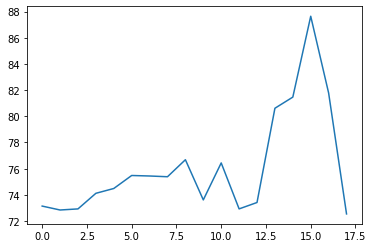

In [134]:
plt.plot(profits);

In [135]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [136]:
print(max_profits)
print(optim_feats)

87.640215
['cf_yield' 'evmq' 'lctq']


In [137]:
# see how the strategy with these features performs on the test set
train_final = train[optim_feats]
test_final = test_original[optim_feats]
bg.fit(train_final, y_train)
pred_test = bg.predict(test_final)
(pred_test * test_ret).sum()

1270.5631709999998

In [139]:
#### backtest using 2010 to 2018 data

In [140]:
# backtest the strategy
start_dates = [pd.to_datetime('2007-01-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

# training dataframes
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [141]:
# drop not useful features 
training_data = [d.reset_index().drop(['ticker','date','next_period_return','spy_next_period_return',\
    'rel_performance','pred_rel_return','return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
test_data = [d.reset_index().drop(['ticker','date','next_period_return','spy_next_period_return',\
    'rel_performance','pred_rel_return','return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]
training_labels = [d['rel_performance'].values for d in training_frames]

# select features
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [142]:
# back test
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
    bg.fit(opt_training_data[i],training_labels[i])
    pred_i = bg.predict(opt_test_data[i])
    profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
    P_L.append(profit_i)
    num_positions = len(pred_i)
    ret.append((1.0/num_positions) * profit_i)
    x.append(x[i] + (x[i]/num_positions) * profit_i)

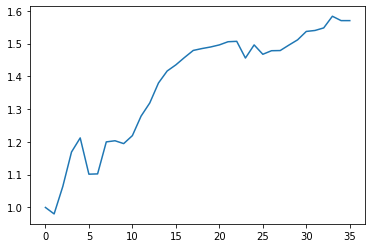

In [143]:
plt.plot(x);

In [158]:
# Obtain the SPY dataset
SPY_cum_ret = pd.DataFrame(raw_data['spy_cum_ret'])
SPY_cum_ret.reset_index(inplace = True)
SPY_cum_ret.set_index('date', inplace = True)
SPY_cum_ret.drop(['ticker'], axis = 1, inplace = True)
SPY_cum_ret = SPY_cum_ret.drop_duplicates()

# truncate the SPY data to the sample period
SPY = SPY_cum_ret.loc['2010-01-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

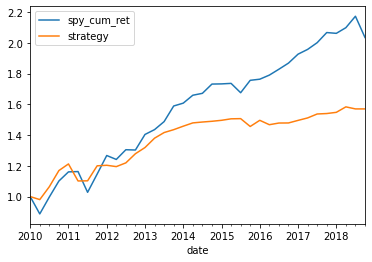

In [159]:
SPY.plot();

In [160]:
### calculate ratios 

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.41229542630645705


In [161]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.457664765255242


In [162]:
x[-1]

1.5698452388194373

In [163]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [164]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.23168687550953107

In [165]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.26069841639493385

In [166]:
alpha = np.mean(residual_ret)
alpha

0.00943540874014259

In [168]:
### Change hyper parameters

# put everything in a function
def tuning_parameters(max_depth, n_est):

    # defind a tree and bagging classifier
    t = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = 800)
    bg = BaggingClassifier(t, n_estimators = n_est, oob_score = True, random_state = 123, n_jobs = 1)

    # fit the model
    bg.fit(train_original, y_train)

    # first find useful features with feature importance function
    fi = baggingtree_feat_importance(bg, train_original)

    # find feafures selected above
    features = fi[(fi['feat_imp'] > 0.01)]

    # truncate the dataframe
    train = train_original[features['cols'].values]
    valid = valid_original[features['cols'].values]

    # remove features and re-train the tree
    profits = []
    feat = []

    train_copy = train.copy()
    valid_copy = valid.copy()

    while len(train_copy.columns)>1:
        
        bg.fit(train_copy, y_train)
        pi = baggingtree_profit_importance(bg, valid_copy, valid_ret)

        col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
        train_copy.drop(col_to_drop,axis=1,inplace=True)
        valid_copy.drop(col_to_drop,axis=1,inplace=True)
        bg.fit(train_copy, y_train)
        
        fi = baggingtree_feat_importance(bg, train_copy)
        features = fi[(fi['feat_imp'] > 0.00)]
        train_copy = train_copy[features['cols'].values]
        valid_copy = valid_copy[features['cols'].values]
        bg.fit(train_copy, y_train)
        
        pred_valid = bg.predict(valid_copy)
        profits.append((pred_valid * valid_ret).sum())
        feat.append(features['cols'].values) 

    # find the final set of features after selection based on profit importance
    n = np.argmax(profits)
    optim_feats = feat[n]

    # backtest the strategy
    start_dates = [pd.to_datetime('2007-01-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
    end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

    # training dataframes
    training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
    test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

    # drop not useful features 
    training_data = [d.reset_index().drop(['ticker','date','next_period_return','spy_next_period_return',\
        'rel_performance','pred_rel_return','return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
    test_data = [d.reset_index().drop(['ticker','date','next_period_return','spy_next_period_return',\
        'rel_performance','pred_rel_return','return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]
    training_labels = [d['rel_performance'].values for d in training_frames]

    # select features
    opt_training_data = [t[optim_feats] for t in training_data]
    opt_test_data = [v[optim_feats] for v in test_data]
    
    # back test
    P_L = []
    x = [1]
    ret = []

    for i in range(len(training_labels)):
        bg.fit(opt_training_data[i],training_labels[i])
        pred_i = bg.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

    # compare it with SPY
    SPY['strategy'] = x
    
    # Sharpe Ratio 
    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std

    # beta
    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

    # Information Ratio
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)

    # alpha
    alpha = np.mean(residual_ret)

    return (x[-1], strategy_sr, beta, IR, alpha), x 

In [171]:
output_1, output_ts_1 = tuning_parameters(5, 50)
output_1

(1.6301247784937032,
 0.43858374207019835,
 0.24993233656023245,
 0.2839536913535313,
 0.01061856441913835)

In [173]:
output_2, output_ts_2 = tuning_parameters(6, 50)
output_2

(1.5934453843878813,
 0.4159188931530594,
 0.2345062859760753,
 0.2675394305512813,
 0.010026390673061254)

In [174]:
output_3, output_ts_3 = tuning_parameters(5, 30)
output_3

(1.6446996848349773,
 0.45661633760685694,
 0.24759850552488252,
 0.302571967142641,
 0.011103950354035842)

In [175]:
output_4, output_ts_4 = tuning_parameters(6, 30)
output_4

(1.5927999270211983,
 0.43442123365768825,
 0.2371844809760475,
 0.2795083594215806,
 0.009928813728153994)

In [ ]:
### question2 

In [177]:
def f2(x):
    if x > 0.05:
        return 2
    elif x > 0.01:
        return 1
    elif x > -0.01:
        return 0
    elif x > -0.05:
        return -1
    else:
        return -2

In [179]:
data['rel_performance'] = data['pred_rel_return'].apply(f2)

In [181]:
output_5, output_ts_5 = tuning_parameters(6, 40)
output_5

(2.6670761856561302,
 0.3417316333691386,
 0.5715335656100137,
 0.2315716397572416,
 0.030743074364959044)

In [182]:
output_6, output_ts_6 = tuning_parameters(5, 30)
output_6

(2.689702013130694,
 0.3370747157435504,
 0.6038123113370908,
 0.22355619970270718,
 0.03043575419977433)

In [183]:
output_7, output_ts_7 = tuning_parameters(6, 50)
output_7

(2.8898130743944304,
 0.3617933194922182,
 0.6106616616679632,
 0.25286769204036924,
 0.03595082848944733)

In [184]:
output_8, output_ts_8 = tuning_parameters(5, 40)
output_8

(2.6604384384708175,
 0.339058063920704,
 0.5618305427716154,
 0.23107084147533039,
 0.03084012936420768)